In [1]:
%load_ext autoreload
%autoreload 2
import torch
import yaml
import logging
from imp import reload
import matplotlib.pyplot as plt
import yaml
import numpy as np
import os
from tqdm import tqdm
from load import load_data
tqdm.get_lock().locks = []
reload(logging)
logger = logging.getLogger(__name__).setLevel(logging.INFO)

# Load data

In [2]:
# declare data parameters
# out 00 -> without bln, 0.004
par_train = {'data_dir'         : '/data/LiftPose3D/capture', # change the path
            #'data_dir'       : r'\Users\NeLy\Desktop\capture', #windows path format
             'out_dir'          : '/data/LiftPose3D/capture/out_across_animals',
             'train_session_id' : [1,2,3],
             'test_session_id'  : [0],
             'test_cam_id'      : [0]}

# merge with training parameters
par_data = yaml.full_load(open('param.yaml', "rb"))
par = {**par_data["data"], **par_train}

In [3]:
train_3d, train_2d, train_keypoints, test_3d, test_2d, test_keypoints, cams, train_fid, test_fid, train_2d_sh, test_2d_sh  = load_data(par_train, return_frame_info=True)

Loading data...
OK


# Train

In [ ]:
from liftpose.main import train as lp3d_train
from liftpose.lifter.augmentation import random_project, perturb_pose, project_to_cam
from liftpose.vision_3d import intrinsic_matrix, calculate_bone_length
from liftpose.preprocess import obtain_projected_stats


# we assume camera-to-object distance and intrinsic matrix are unknown
angle_aug = {'eangles': {0: [[-10,10], [-10, 10], [-10,10]]},
            'axsorder': 'zyx',
            'vis': None,
            'tvec': None,
            'intr': None}

bone_len = calculate_bone_length(test_3d, par_data['vis']['bones'])
avg_bone_len= np.nanmean(bone_len, axis=0)
std_bone_len= np.nanstd(bone_len, axis=0)

pose_aug = {'perturb': 2,
            'child': par_data["vis"]["child"],
            'bones': par_data['vis']['bones'],
            'avg_bone_len': avg_bone_len,
            'std_bone_len': std_bone_len}


stats = obtain_projected_stats({'train_3d':train_3d},
                               angle_aug['eangles'], 
                               angle_aug['axsorder'], 
                               angle_aug['vis'],
                               angle_aug['tvec'],
                               angle_aug['intr'],
                               par['roots'], 
                               par['target_sets'],
                               par['out_dir'],
                               load_existing=True,
                               th=1)

aug = [perturb_pose(**pose_aug), random_project(**angle_aug)]
#aug = [random_project(**angle_aug)]

lp3d_train(train_2d=None, test_2d={'test':test_2d},
           train_3d={'train':train_3d}, test_3d={'test':test_3d},
           train_keypts={'train':train_keypoints}, test_keypts={'test':test_keypoints}, 
           roots=par['roots'],
           target_sets=par['target_sets'],
           out_dir=par['out_dir'], 
           training_kwargs={"epochs":15,
                            "resume":True,
                            "load":par['out_dir'] + '/ckpt_last.pth.tar'},
           augmentation=aug,
           stats=stats,
           norm_2d=True
          )

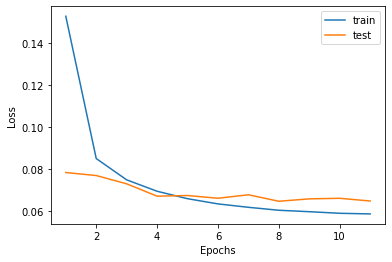

In [4]:
%matplotlib inline
from liftpose.plot import read_log_train, plot_log_train
epoch, lr, loss_train, loss_test, err_test = read_log_train(par['out_dir'])
plot_log_train(plt.gca(), loss_train, loss_test, epoch)

In [5]:
from liftpose.main import test as lp3d_test
lp3d_test(par['out_dir'])

[main.py:392]:INFO:starting testing in path: /data/LiftPose3D/capture/out_across_animals
[lift.py:29]:INFO:Training on the device: cuda:0
[lift.py:56]:INFO:total params: 4.31M
[lift.py:64]:INFO:loading ckpt from '/data/LiftPose3D/capture/out_across_animals/ckpt_best.pth.tar'
[lift.py:72]:INFO:ckpt loaded (epoch: 11 | err: 5.615852821748582)
[lift.py:106]:INFO:Saving results: /data/LiftPose3D/capture/out_across_animals/test_results.pth.tar


In [6]:
from liftpose.postprocess import load_test_results
from liftpose.vision_3d import camera_to_world, pairwise_procrustes

test_3d_gt, test_3d_pred, good_keypts = load_test_results(par['out_dir'])

s = test_3d_gt.shape
test_3d_gt = camera_to_world(test_3d_gt.reshape(s[0], -1), cams['R'][0], cams['tvec'][0]).reshape(s)
test_3d_pred = camera_to_world(test_3d_pred.reshape(s[0],-1), cams['R'][0], cams['tvec'][0]).reshape(s)

#change occluded points to nana
ind_nan_pred = np.logical_not(test_keypoints)
ind_nan_gt = np.logical_not(test_keypoints)
ind_nan = (ind_nan_gt*ind_nan_pred).reshape(-1, 20, 3)
test_3d_pred[ind_nan] = np.nan
test_3d_gt[ind_nan] = np.nan

#make nans to zeros for procrustes
test_3d_pred[np.isnan(test_3d_pred)]=0
test_3d_gt[np.isnan(test_3d_gt)]=0

#remove all-0 poses
ind_0_pred = (test_3d_pred.sum(2).sum(1)>0)
ind_0_gt = (test_3d_gt.sum(2).sum(1)>0)
ind_0 = ind_0_pred*ind_0_gt
test_3d_pred = test_3d_pred[ind_0]
test_3d_gt = test_3d_gt[ind_0]
test_fid = test_fid[ind_0]
test_2d_sh = test_2d_sh[ind_0]

#procrustes align
test_3d_pred = pairwise_procrustes(test_3d_gt, test_3d_pred)

#put nans back
test_3d_gt[ind_nan[ind_0]]=np.nan
test_3d_pred[ind_nan[ind_0]]=np.nan

# Visualize Predictions

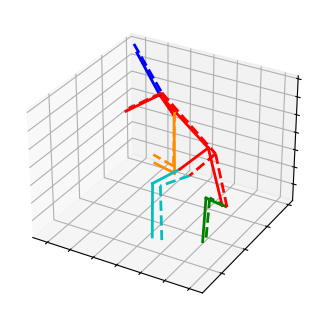

In [7]:
#%matplotlib widget
%matplotlib inline
from liftpose.plot import plot_pose_3d
fig = plt.figure(figsize=plt.figaspect(1), dpi=100)
ax = fig.add_subplot(111, projection='3d')
i=5
plot_pose_3d(ax=ax, tar=test_3d_gt[i],
             pred=test_3d_pred[i],
            bones=par_data["vis"]["bones"], 
            limb_id=par_data["vis"]["limb_id"], 
            colors=par_data["vis"]["colors"], 
            normalize=False, show_pred_always=True)


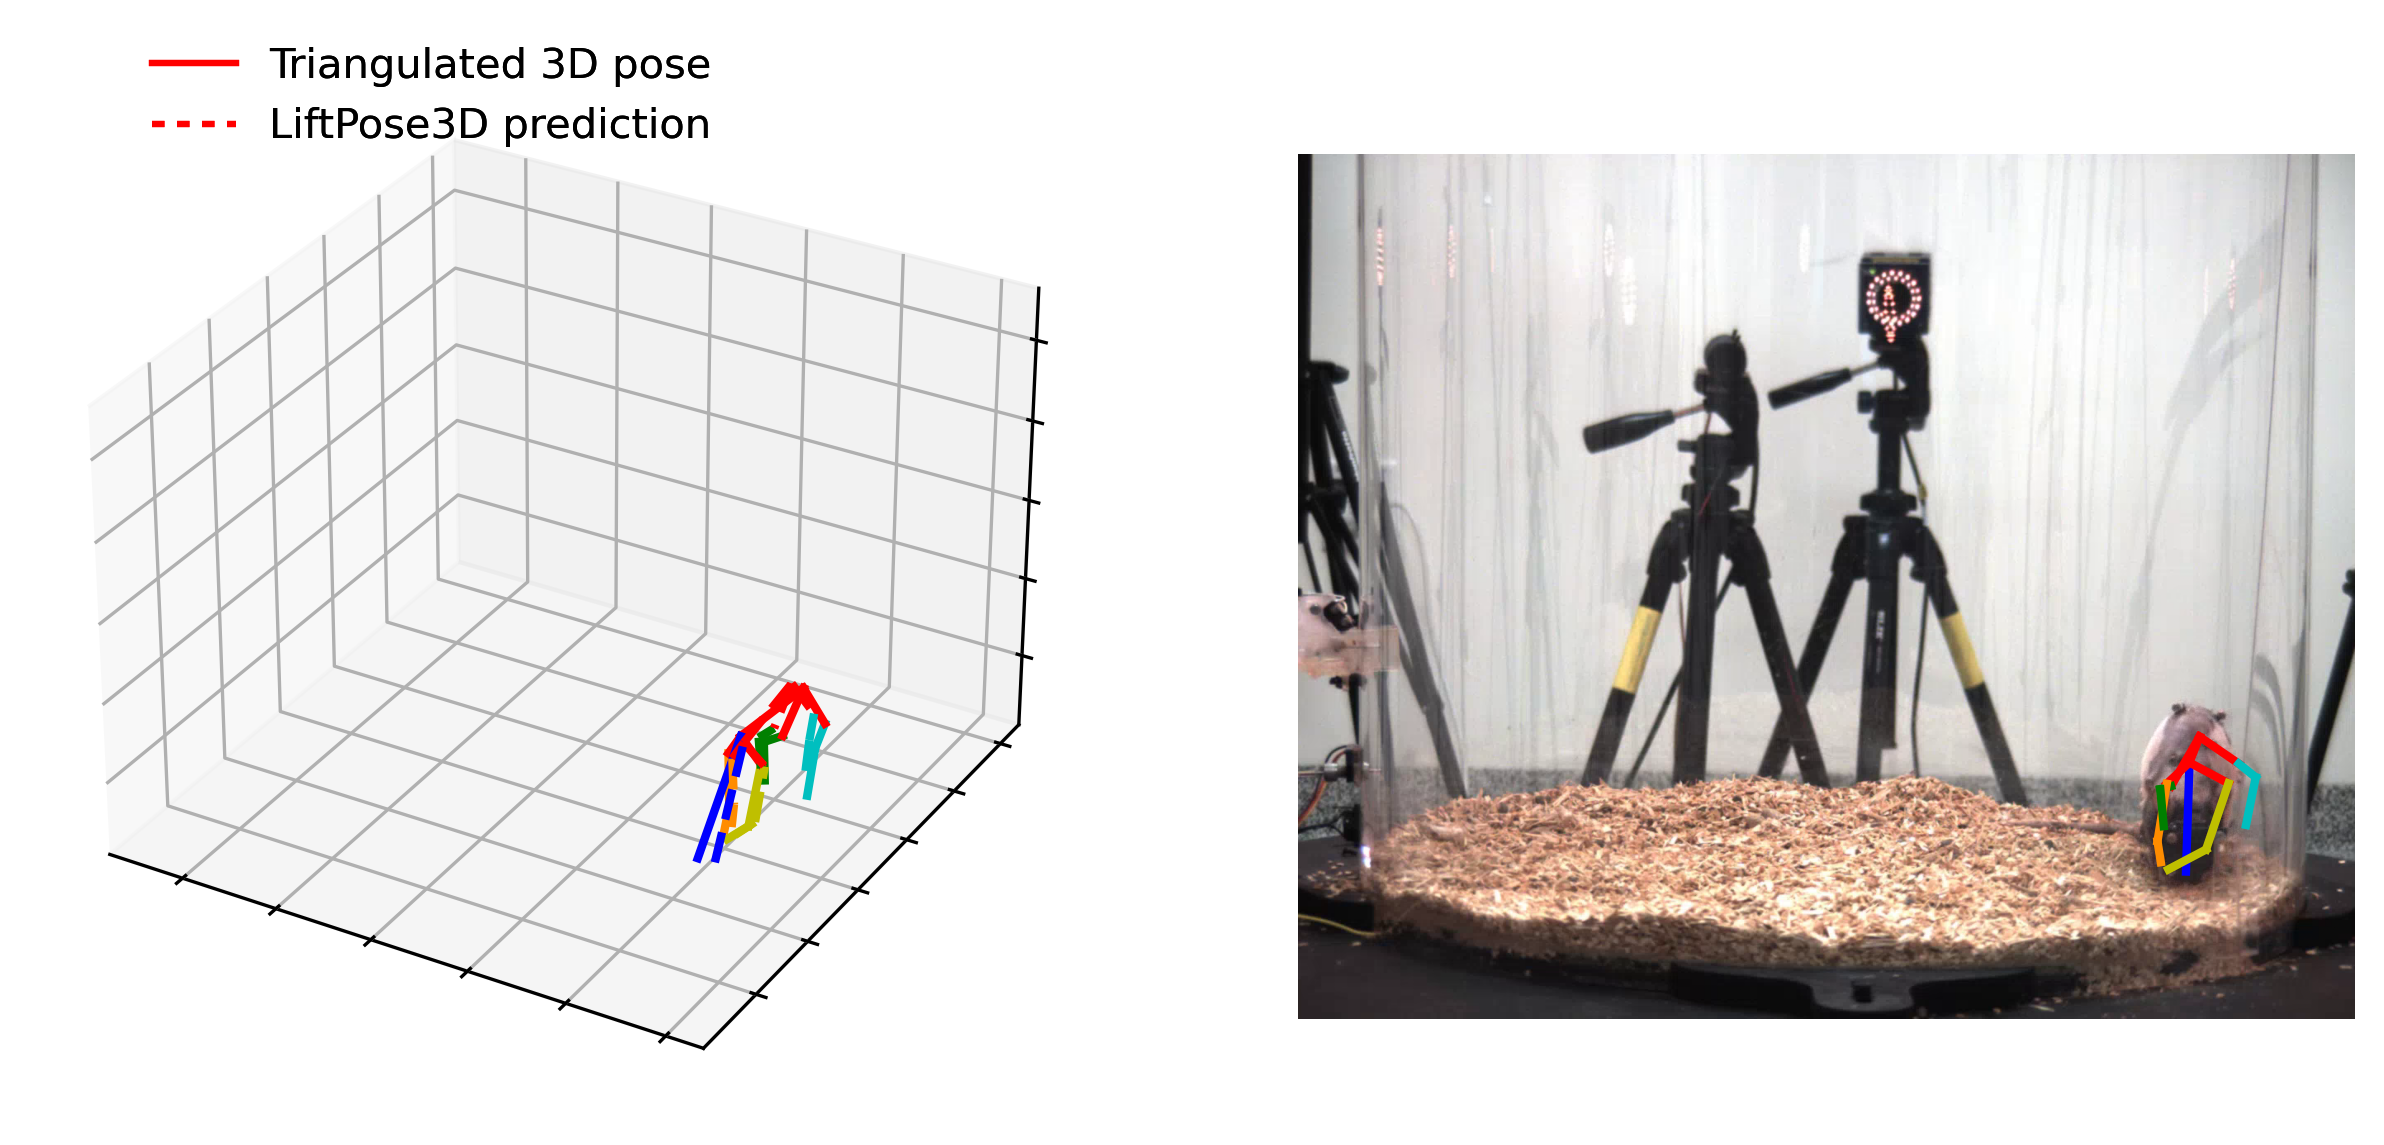

In [8]:
%matplotlib inline
from celluloid import Camera
from liftpose.plot import plot_pose_2d, plot_pose_3d

fig = plt.figure(figsize=(10,5), dpi=300)
ax = fig.add_subplot(121, projection='3d')
ax2 = fig.add_subplot(122)

cam_list = ['R', 'L', 'E', 'U', 'S', 'U2']
camera = Camera(fig)
for t in range(0, 5000):
    frame_id = test_fid[t][0]
    if os.path.isfile(f'/mnt/NAS/SG/CAPTURE/images/rat7M_e0/sample0_{frame_id}_Camera{cam_list[0]}.png'):
    
        plot_pose_3d(ax=ax, tar=test_3d_gt[t], 
            pred=test_3d_pred[t], 
            bones=par_data["vis"]["bones"], 
            limb_id=par_data["vis"]["limb_id"], 
            colors=par_data["vis"]["colors"],
            normalize=False,
            legend=True)
    
        ax2.imshow(plt.imread(f'/mnt/NAS/SG/CAPTURE/images/rat7M_e0/sample0_{frame_id}_Camera{cam_list[0]}.png'))
        
        pt = test_2d_sh[t].reshape(-1,2)
        plot_pose_2d(ax2, 
            pt, 
            bones=par_data["vis"]["bones"], 
            limb_id=par_data["vis"]["limb_id"], 
            colors=par_data["vis"]["colors"],
            normalize=False
        )
        ax2.axis('off')
        camera.snap()
        
camera.animate().save('prediction.mp4')

Bone lengths

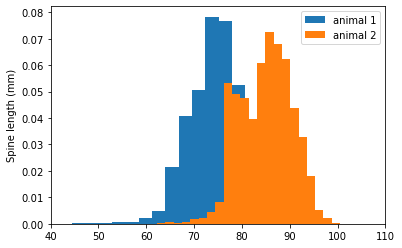

In [9]:
from liftpose.vision_3d import calculate_bone_length
bl_animal_1 = calculate_bone_length(train_3d, par_data['vis']['bones'])
bl_animal_2 = calculate_bone_length(test_3d, par_data['vis']['bones'])
plt.hist(bl_animal_1[:,1],label='animal 1',bins=100,density=True)
plt.hist(bl_animal_2[:,1],label='animal 2',bins=100,density=True)
plt.xlim([40,110])
plt.ylabel('Spine length (mm)')
#plt.savefig('spine_length.svg')
plt.legend()

# Errors

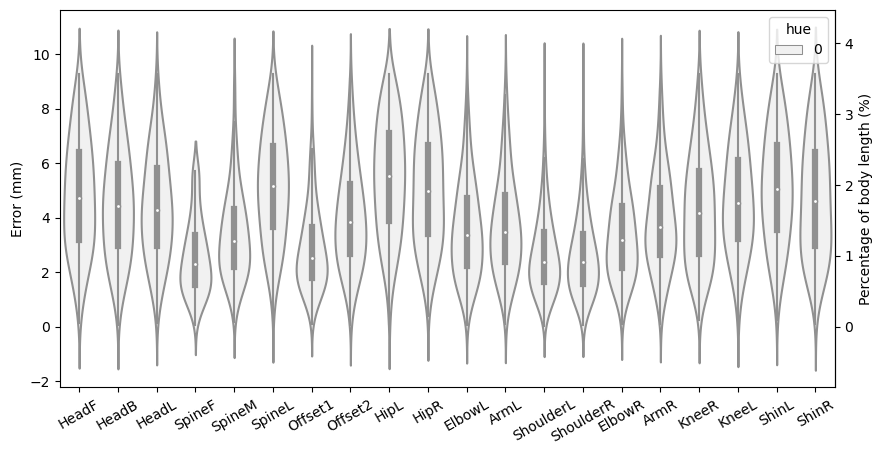

In [12]:
%matplotlib inline
from liftpose.plot import violin_plot
import random, string
plt.figure(figsize=(10,5), dpi=100)
names = ['HeadF','HeadB','HeadL','SpineF','SpineM','SpineL','Offset1','Offset2','HipL','HipR',
         'ElbowL','ArmL','ShoulderL','ShoulderR','ElbowR','ArmR','KneeR','KneeL','ShinL','ShinR']
ax = plt.gca()
violin_plot(ax, test_3d_gt=test_3d_gt, test_3d_pred=test_3d_pred, test_keypoints=np.ones_like(test_3d_gt),
                joints_name=names, order=names, units='mm', body_length=260)
#plt.savefig('errors_norm.svg')